In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import nltk
from nltk.tokenize import word_tokenize
from datasets import load_dataset

In [2]:
### Hyper Params
batch_size = 1
hidden_size = 120
input_size = 120
embed_dim = 120
lr = 0.001
epochs = 50
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
raw_dataset = load_dataset("jaydenccc/AI_Storyteller_Dataset", split="train")['short_story']

In [4]:
nltk.download('punkt_tab')

text_corpus = ""
for item in raw_dataset:
    text_corpus += item.lower()

text_corpus = text_corpus.replace('.', '').replace(',','').replace('\n',' ').replace('\'', '').replace('\"', '').replace(':', '').replace('?', '').replace('!', '').replace(';', '').replace('-', '')

tokens = word_tokenize(text_corpus)
tokens = [item for item in tokens if item not in ['the', '']]

unique_words = set(tokens)
word_to_num = {word: idx for idx, word in enumerate(unique_words)}
num_to_word = {idx: word for idx, word in enumerate(unique_words)}

[nltk_data] Downloading package punkt_tab to /home/grant/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
output_size = len(word_to_num)

pad_tok_id = output_size
num_to_word[pad_tok_id] = '<pad>'
word_to_num['<pad>'] = pad_tok_id

num_to_word[output_size+1] = ''
word_to_num[''] = output_size+1

output_size = len(word_to_num)

In [6]:
class StoryDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [7]:
pads = ['<pad>' for i in range(9)]
corpus = text_corpus.split(' ')
corpus = [item for item in corpus if item not in ['the', '']]

train_dataset = StoryDataset(corpus[:25000])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

test_dataset = StoryDataset(corpus[25000:])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [8]:
class Net(nn.Module):
    def __init__(self, input_size, output_size, embed_dim, vocab_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.fc = nn.Sequential(
            nn.Linear(input_size, 120),
            nn.GELU(),
            # nn.ReLU(),
            nn.Linear(120, 240),
            nn.GELU(),
            # nn.ReLU(),
            nn.Linear(240, output_size)
        )
    def forward(self, x):
        embedded = self.embed(x)
        embedded = embedded.view(embedded.size(0), -1)
        return self.fc(embedded)
        # return torch.argmax(x, dim=0)

In [9]:
net = Net(input_size, output_size, embed_dim, len(num_to_word)).to(device)
crit = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=lr)

In [10]:
avg_loss = 0
net.train()
for epoch in range(epochs):
    for i, item in enumerate(train_dataset):
        if i < len(train_dataset) - 1:
            opt.zero_grad()
            # Prepare input and target
            # input_tensor = torch.tensor([[word_to_num[item]]], dtype=torch.long)
            # # target_tensor = torch.tensor([word_to_num[train_dataset[i+1]]], dtype=torch.long).to(device)
            # target_tensor = torch.zeros(1, 4588, dtype=torch.long)
            # target_tensor[0, word_to_num[train_dataset[i+1]]] = 1

            # input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

            input_tensor = torch.tensor([[word_to_num[item]]], dtype=torch.long).to(device)
            target_tensor = torch.tensor([word_to_num[train_dataset[i + 1]]], dtype=torch.long).to(device)
            
            # Forward pass
            output = net(input_tensor)
            # Compute loss
            loss = crit(output, target_tensor)
            loss.backward()
            opt.step()
            avg_loss += loss.item()

        # if i % 10000 == 0:
        #     print(f'Loss: {avg_loss/10000}, Step: {i}/{len(train_dataset)*epochs}, Epoch: {epoch}/{epochs-1}')
        #     avg_loss = 0
    
    print(f'Loss: {avg_loss/25000}, Epoch: {epoch+1}/{epochs}')
    torch.save(net.state_dict(), f"rnn-nlp-epoch-{epoch}.pth")
    avg_loss = 0

Loss: 6.903551365067418, Epoch: 1/50
Loss: 6.689913034522072, Epoch: 2/50
Loss: 6.563159259649946, Epoch: 3/50
Loss: 6.380579395937433, Epoch: 4/50
Loss: 6.2008056386745185, Epoch: 5/50
Loss: 6.061294905322877, Epoch: 6/50
Loss: 5.938598689933577, Epoch: 7/50
Loss: 5.846441353606858, Epoch: 8/50
Loss: 5.766433396298639, Epoch: 9/50
Loss: 5.681622043591896, Epoch: 10/50
Loss: 5.624921192635954, Epoch: 11/50
Loss: 5.560673291829478, Epoch: 12/50
Loss: 5.510109524559659, Epoch: 13/50
Loss: 5.455990849814052, Epoch: 14/50
Loss: 5.412311597060608, Epoch: 15/50
Loss: 5.402452818609428, Epoch: 16/50
Loss: 5.371902284716587, Epoch: 17/50
Loss: 5.355709599562171, Epoch: 18/50
Loss: 5.330054915959479, Epoch: 19/50
Loss: 5.318743065410997, Epoch: 20/50
Loss: 5.304307303036016, Epoch: 21/50
Loss: 5.29314997153857, Epoch: 22/50
Loss: 5.274410574701499, Epoch: 23/50
Loss: 5.267184158877183, Epoch: 24/50
Loss: 5.238924741789027, Epoch: 25/50
Loss: 5.2070799644536185, Epoch: 26/50
Loss: 5.235889359142

In [ ]:
PATH = './next_word_2.pth'
torch.save(net.state_dict(), PATH)

In [11]:
seq_len = 100
seq = []
cur = "protecting"

for i in range(seq_len):
    print(cur)
    next_tok = net(torch.tensor([[word_to_num[cur]]], dtype=torch.long).to(device))
    cur = num_to_word[torch.argmax(next_tok).item()]

protecting
her
that
she
had
to
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a
chain
of
a


Word: the


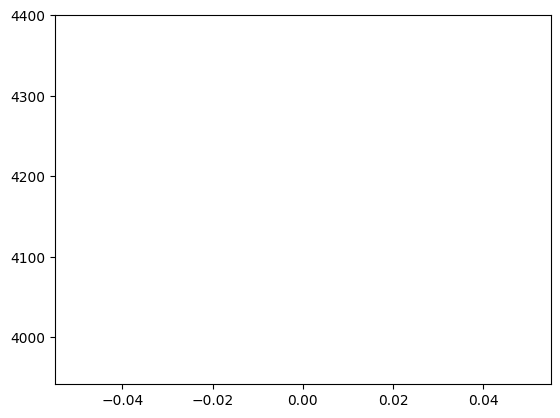

In [20]:
import matplotlib.pyplot as plt

input_tensor = torch.tensor([[word_to_num["the"]]], dtype=torch.float32)

# Forward pass
output = torch.argmax(net(input_tensor))
print(f'Word: {num_to_word[output.item()]}')

plot = output.detach().numpy()
plt.plot(plot)
plt.show()
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(fc1_logits[0])), fc1_logits[0], color='blue', alpha=0.7)
# plt.title("Logits from fc1 Layer")
# plt.xlabel("Neuron Index")
# plt.ylabel("Logit Value")
# plt.show()

In [9]:
class RNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Init hidden state (batch size * hidden size)
        batch_size = x.size(0)
        hidden = torch.zeros(1, batch_size, self.hidden_size) # 

        # Forward through net
        out, hidden = self.rnn(x, hidden)

        # Only use last hidden state for output
        out = self.fc(out[:, -1, :])
        return out

In [12]:
import torch
import torch.nn.functional as F

# Example tensor
tensor = torch.rand(1, 4500)  # Shape [1, 4500]

# Apply softmax
softmax_probs = F.softmax(tensor, dim=1)

import numpy as np

# Convert to NumPy array
softmax_probs_np = softmax_probs.squeeze(0).detach().cpu().numpy()  # Shape [4500]

import matplotlib.pyplot as plt

# Plot the top 10 probabilities
top_k = 10
top_probs, top_indices = torch.topk(softmax_probs, top_k)

top_probs_np = top_probs.squeeze(0).detach().cpu().numpy()
top_indices_np = top_indices.squeeze(0).detach().cpu().numpy()

plt.bar(range(top_k), top_probs_np, tick_label=top_indices_np)
plt.title("Top 10 Probabilities")
plt.xlabel("Indices")
plt.ylabel("Probability")
plt.show()